## 对实测数据进行插值，使其在时间序列上连续

In [44]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.io as sio

### 加载已去除异常值的real数据

In [45]:
## 读取real数据
with open('../data/real_dataset_target', 'rb') as f:
    real_target = pickle.load(f)

In [46]:
real_target

,站位编号,获取时间,经度,纬度,平均风速,平均风向,平均风速_10m
0,0,1.630541e+09,113.45481,21.56127,4.80,0.30000,5.693471
1,0,1.630542e+09,113.45481,21.56127,4.90,108.90000,5.812085
2,0,1.630543e+09,113.45481,21.56127,4.70,73.10000,5.574857
3,0,1.630543e+09,113.45481,21.56127,4.50,157.10000,5.337629
4,0,1.630544e+09,113.45481,21.56127,5.20,52.50000,6.167927
...,...,...,...,...,...,...,...
59261,3,1.634357e+09,113.77757,20.87868,8.20,109.50000,9.726346
59262,3,1.634358e+09,113.77757,20.87868,7.70,136.00000,9.133276
59263,3,1.634359e+09,113.77757,20.87868,8.80,95.79999,10.438030
59264,3,1.634359e+09,113.77757,20.87868,9.00,96.70001,10.675258


#### 将real插值到等时间间隔（10min）

In [47]:
# # 提取数据
# 观测数据分组（分站位）
df_group = real_target.groupby('站位编号')

# 0号站位
real_velocity_00 = df_group.get_group(0)['平均风速_10m'].values
real_degree_00 = df_group.get_group(0)['平均风向'].values
real_time_00 = df_group.get_group(0)['获取时间'].values

# 1号站位
real_velocity_01 = df_group.get_group(1)['平均风速_10m'].values
real_degree_01 = df_group.get_group(1)['平均风向'].values
real_time_01 = df_group.get_group(1)['获取时间'].values

# 2号站位
real_velocity_02 = df_group.get_group(2)['平均风速_10m'].values
real_degree_02 = df_group.get_group(2)['平均风向'].values
real_time_02 = df_group.get_group(2)['获取时间'].values

# 3号站位
real_velocity_03 = df_group.get_group(3)['平均风速_10m'].values
real_degree_03 = df_group.get_group(3)['平均风向'].values
real_time_03 = df_group.get_group(3)['获取时间'].values

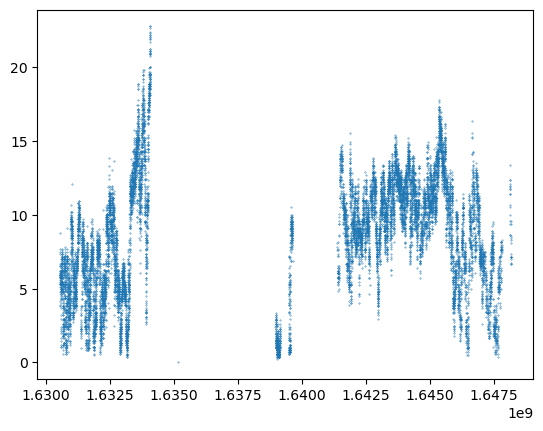

In [48]:
# 0号站位
plt.scatter(real_time_00, real_velocity_00, s=0.1)

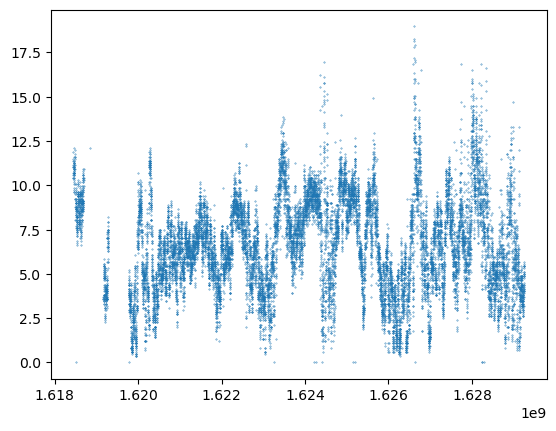

In [49]:
# 1号站位
plt.scatter(real_time_01, real_velocity_01, s=0.1)

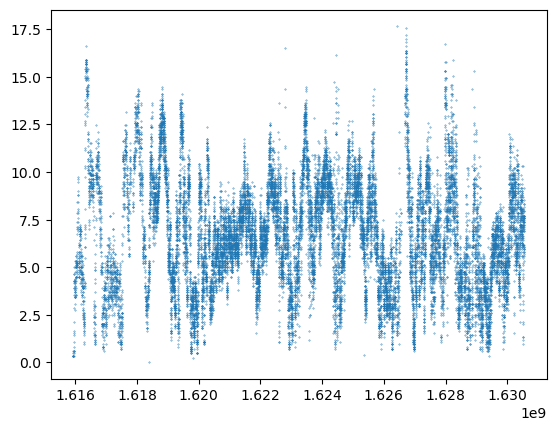

In [50]:
# 2号站位
plt.scatter(real_time_02, real_velocity_02, s=0.1)

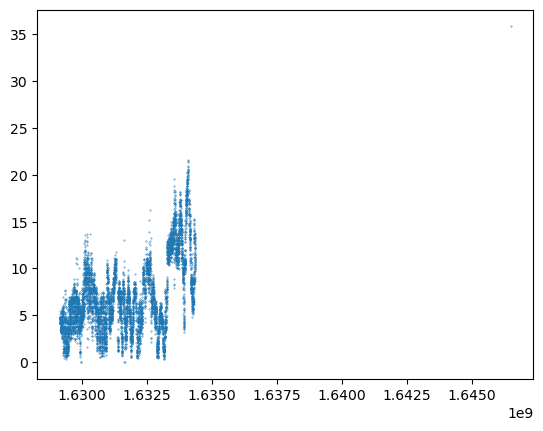

In [51]:
# 3号站位
plt.scatter(real_time_03, real_velocity_03, s=0.1)

In [52]:
real_time_02.shape

(20858,)

In [53]:
# # 基于数据的连续性 选取 02站位 进行建模
# 起始时间
time_start_02, time_end_02 = pd.to_datetime([real_time_02[0], real_time_02[-1]], unit='s')
print(time_start_02, time_end_02)

# 构建等间隔的目标时间轴
date_target_02 = pd.date_range(start=time_start_02, end=time_end_02, freq='10T')
time_target_02 = date_target_02.astype('int64').to_numpy()/10**9

2021-03-17 00:00:00 2021-09-02 02:00:00


In [54]:
date_target_02

DatetimeIndex(['2021-03-17 00:00:00', '2021-03-17 00:10:00',
               '2021-03-17 00:20:00', '2021-03-17 00:30:00',
               '2021-03-17 00:40:00', '2021-03-17 00:50:00',
               '2021-03-17 01:00:00', '2021-03-17 01:10:00',
               '2021-03-17 01:20:00', '2021-03-17 01:30:00',
               ...
               '2021-09-02 00:30:00', '2021-09-02 00:40:00',
               '2021-09-02 00:50:00', '2021-09-02 01:00:00',
               '2021-09-02 01:10:00', '2021-09-02 01:20:00',
               '2021-09-02 01:30:00', '2021-09-02 01:40:00',
               '2021-09-02 01:50:00', '2021-09-02 02:00:00'],
              dtype='datetime64[ns]', length=24349, freq='10T')

In [55]:
# 判断原始时间轴 和 目标时间轴 的起始时间 是否相同
print(time_target_02[0] == real_time_02[0] and time_target_02[-1] == real_time_02[-1])

True


In [56]:
# # 插值前的数据检查
# 是否有nan
print(np.where(np.isnan(real_time_02)), 
      np.where(np.isnan(real_velocity_02)), 
      np.where(np.isnan(real_degree_02)))

# 插值轴是否单调递增
gradient = np.gradient(real_time_02)  
is_increasing = np.all(gradient >= 0)  
print(is_increasing)  # 输出: True则为单调递增

(array([], dtype=int64),) (array([], dtype=int64),) (array([100], dtype=int64),)
True


In [57]:
# # 双线性插值
# 插值器
f_velocity = interp1d(real_time_02, real_velocity_02, kind='linear')
f_degree = interp1d(real_time_02, real_degree_02, kind='linear')
# 插值目标时间轴
real_velocity_target_02 = f_velocity(time_target_02)
real_degree_target_02 = f_degree(time_target_02)

### 10分钟等间距数据可视化

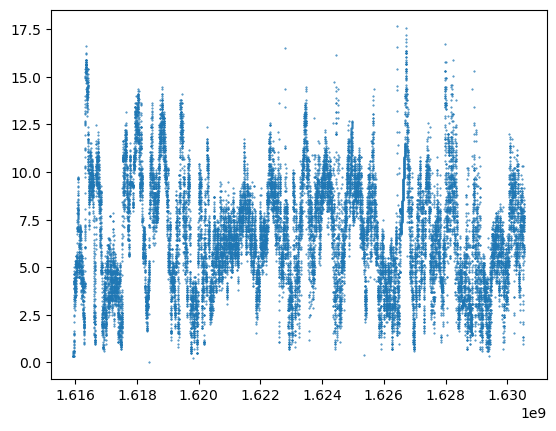

In [58]:
plt.scatter(time_target_02, real_velocity_target_02, s=0.2)

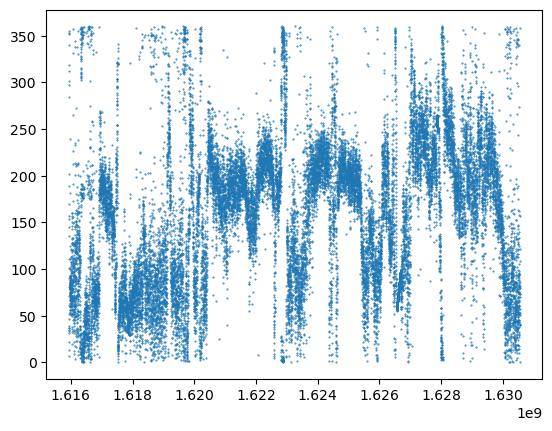

In [59]:
plt.scatter(time_target_02, real_degree_target_02, s=0.2)

### wrf数据插值到目标时间轴

In [68]:
# 加载数据--wrf
dataset_02 = sio.loadmat(r'../data/idw_02_100.mat')
print(dataset_02.keys())
## 读取WRF数据
with open('../data/wrf_dataset_init', 'rb') as f:
    wrf_init = pickle.load(f)

dict_keys(['__header__', '__version__', '__globals__', 'idw_velocity10', 'idw_degree', 'idw_u10', 'idw_v10', 'idw_rh2', 'idw_t2', 'idw_slp'])


In [73]:
# 提取数据
wrf_time = wrf_init['time'].flatten()

wrf_velocity_02 = dataset_02['idw_velocity10'].flatten()
wrf_degree_02 = dataset_02['idw_degree'].flatten()
wrf_u_02 = dataset_02['idw_u10'].flatten()
wrf_v_02 = dataset_02['idw_v10'].flatten()
wrf_rh2_02 = dataset_02['idw_rh2'].flatten()
wrf_t2_02 = dataset_02['idw_t2'].flatten()
wrf_slp_02 = dataset_02['idw_slp'].flatten()

In [74]:
# 查看数据长度
print(len(wrf_velocity_02) == len(wrf_time))

True


In [75]:
# 插值到目标时间轴
# 插值器
f_velocity = interp1d(wrf_time, wrf_velocity_02, kind='linear')
f_degree = interp1d(wrf_time, wrf_degree_02, kind='linear')
f_u = interp1d(wrf_time, wrf_u_02, kind='linear')
f_v = interp1d(wrf_time, wrf_v_02, kind='linear')
f_rh2 = interp1d(wrf_time, wrf_rh2_02, kind='linear')
f_t2 = interp1d(wrf_time, wrf_t2_02, kind='linear')
f_slp = interp1d(wrf_time, wrf_slp_02, kind='linear')
# 插值目标时间轴
wrf_velocity_target_02 = f_velocity(time_target_02)
wrf_degree_target_02 = f_degree(time_target_02)
wrf_u_target_02 = f_u(time_target_02)
wrf_v_target_02 = f_v(time_target_02)
wrf_rh2_target_02 = f_rh2(time_target_02)
wrf_t2_target_02 = f_t2(time_target_02)
wrf_slp_target_02 = f_slp(time_target_02)

### 10分钟等间距数据可视化

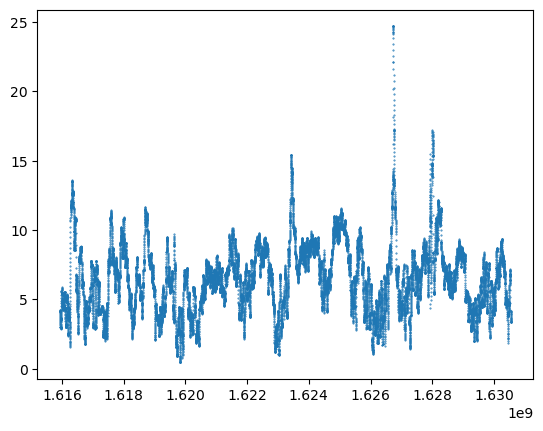

In [76]:
plt.scatter(time_target_02, wrf_velocity_target_02, s=0.2)

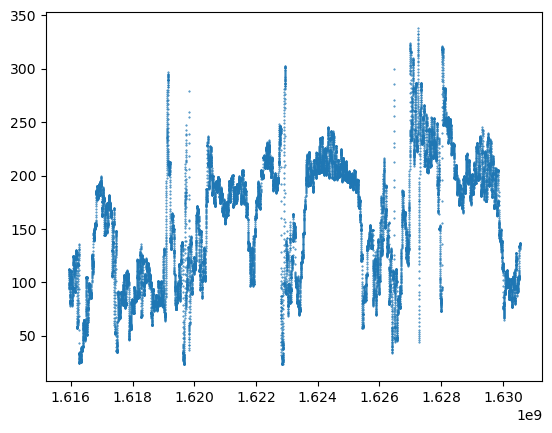

In [77]:
plt.scatter(time_target_02, wrf_degree_target_02, s=0.2)

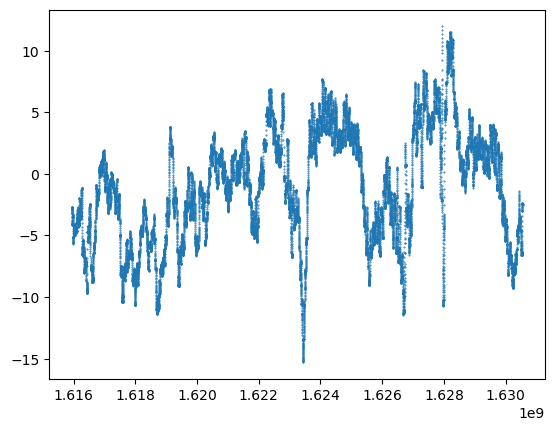

In [78]:
plt.scatter(time_target_02, wrf_u_target_02, s=0.2)

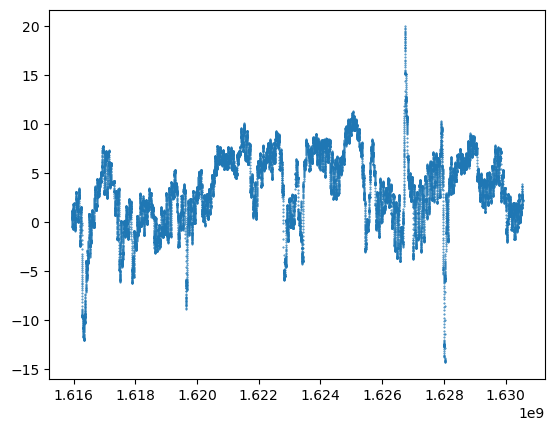

In [79]:
plt.scatter(time_target_02, wrf_v_target_02, s=0.2)

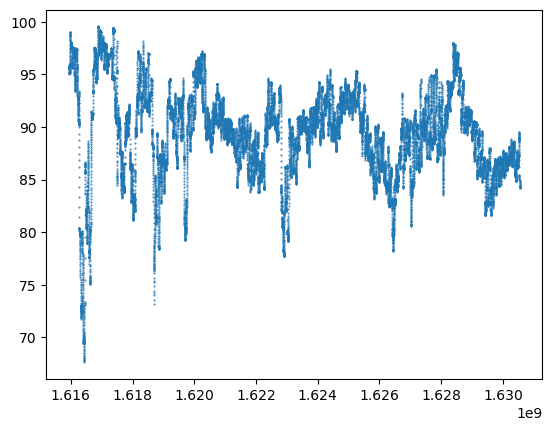

In [80]:
plt.scatter(time_target_02, wrf_rh2_target_02, s=0.2)

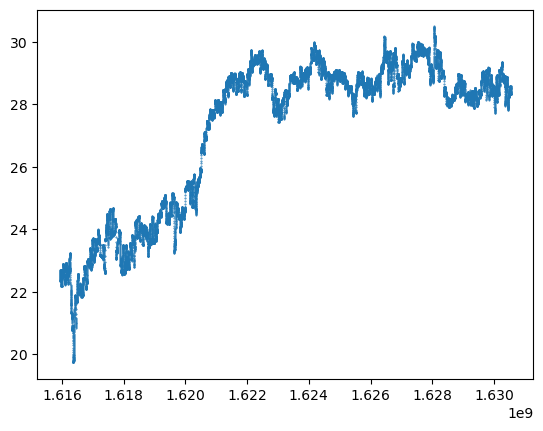

In [81]:
plt.scatter(time_target_02, wrf_t2_target_02, s=0.2)

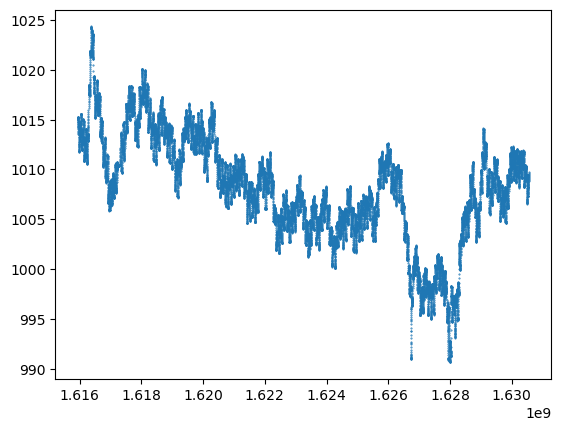

In [82]:
plt.scatter(time_target_02, wrf_slp_target_02, s=0.2)

### 数据平滑--把时间分辨率为10分钟的数据 处理为 时间分辨率为1小时的数据

In [83]:
# # 数据平滑参数
# 数据量
sample_num = int((len(time_target_02) - 1) / 6) # 剔除掉最后一个数据
# 窗口大小
interval = 6
# 起算索引
index = 0
# 累加数据量
num = 1

In [84]:
# # 1hr 数据的时间轴
date_1h_02 = pd.date_range(start=time_start_02, end=time_end_02, freq='H') + pd.to_timedelta('30min')
# 特殊处理，去除最后一个数据
date_1h_02 = date_1h_02[:-1]
# 转为数组
time_1h_02 = date_1h_02.astype('int64').to_numpy()/10**9
print('构建状态：', len(time_1h_02) == sample_num)

构建状态： True


In [85]:
date_1h_02

DatetimeIndex(['2021-03-17 00:30:00', '2021-03-17 01:30:00',
               '2021-03-17 02:30:00', '2021-03-17 03:30:00',
               '2021-03-17 04:30:00', '2021-03-17 05:30:00',
               '2021-03-17 06:30:00', '2021-03-17 07:30:00',
               '2021-03-17 08:30:00', '2021-03-17 09:30:00',
               ...
               '2021-09-01 16:30:00', '2021-09-01 17:30:00',
               '2021-09-01 18:30:00', '2021-09-01 19:30:00',
               '2021-09-01 20:30:00', '2021-09-01 21:30:00',
               '2021-09-01 22:30:00', '2021-09-01 23:30:00',
               '2021-09-02 00:30:00', '2021-09-02 01:30:00'],
              dtype='datetime64[ns]', length=4058, freq='H')

In [86]:
# # 数据容器
real_velocity_mean_02 = np.zeros((sample_num))
real_degree_mean_02 = np.zeros((sample_num))

wrf_velocity_mean_02 = np.zeros((sample_num))
wrf_degree_mean_02 = np.zeros((sample_num))
wrf_u_mean_02 = np.zeros((sample_num))
wrf_v_mean_02 = np.zeros((sample_num))
wrf_rh2_mean_02 = np.zeros((sample_num))
wrf_t2_mean_02 = np.zeros((sample_num))
wrf_slp_mean_02 = np.zeros((sample_num))

# # 数据平滑
while num <= sample_num:
    # 观测数据--1hr平均
    real_velocity_mean_02[num - 1] = np.mean(real_velocity_target_02[index: index+interval])
    real_degree_mean_02[num - 1] = np.mean(real_degree_target_02[index: index+interval])
    # wrf数据--1hr平均
    wrf_velocity_mean_02[num - 1] = np.mean(wrf_velocity_target_02[index: index+interval])
    wrf_degree_mean_02[num - 1] = np.mean(wrf_degree_target_02[index: index+interval])
    wrf_u_mean_02[num - 1] = np.mean(wrf_u_target_02[index: index+interval])
    wrf_v_mean_02[num - 1] = np.mean(wrf_v_target_02[index: index+interval])
    wrf_rh2_mean_02[num - 1] = np.mean(wrf_rh2_target_02[index: index+interval])
    wrf_t2_mean_02[num - 1] = np.mean(wrf_t2_target_02[index: index+interval])
    wrf_slp_mean_02[num - 1] = np.mean(wrf_slp_target_02[index: index+interval])
    
    # 更新迭代参数
    index += 6
    num += 1
print('已处理数据量为：', num - 1, '\t状态：', (num - 1) == sample_num)

已处理数据量为： 4058 	状态： True


### 1hr平均数据可视化

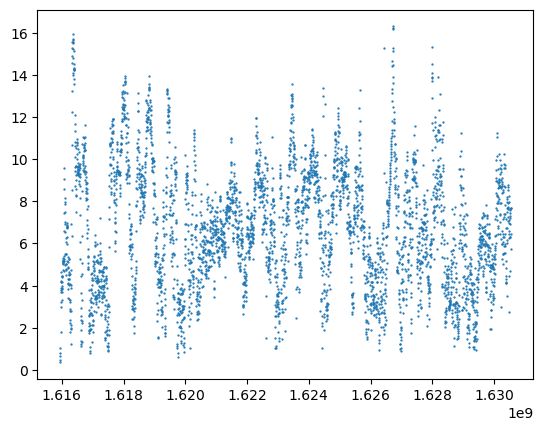

In [87]:
plt.scatter(time_1h_02, real_velocity_mean_02, s=0.4)

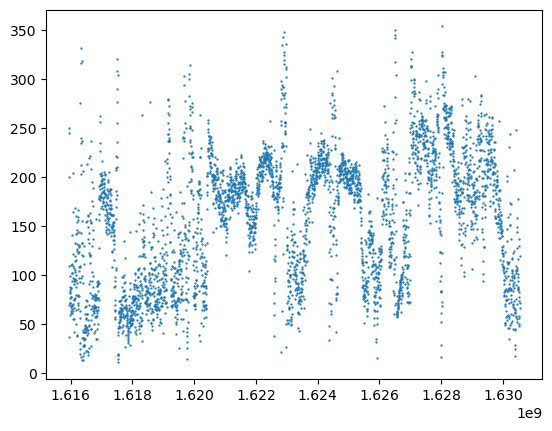

In [88]:
plt.scatter(time_1h_02, real_degree_mean_02, s=0.4)

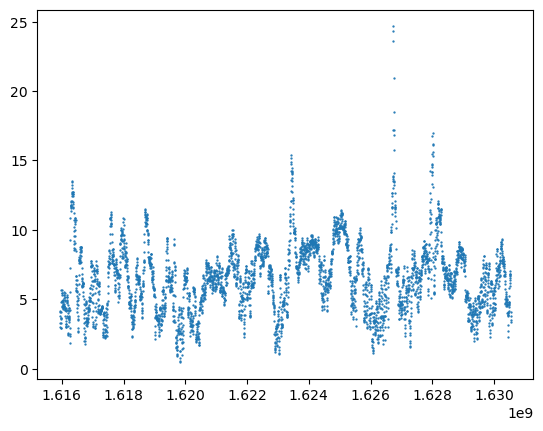

In [89]:
plt.scatter(time_1h_02, wrf_velocity_mean_02, s=0.4)

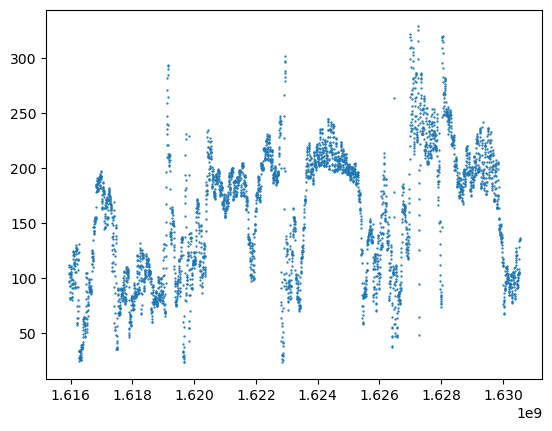

In [90]:
plt.scatter(time_1h_02, wrf_degree_mean_02, s=0.4)

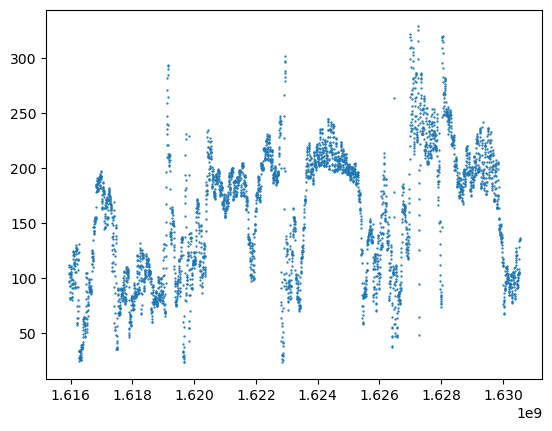

In [91]:
plt.scatter(time_1h_02, wrf_degree_mean_02, s=0.4)

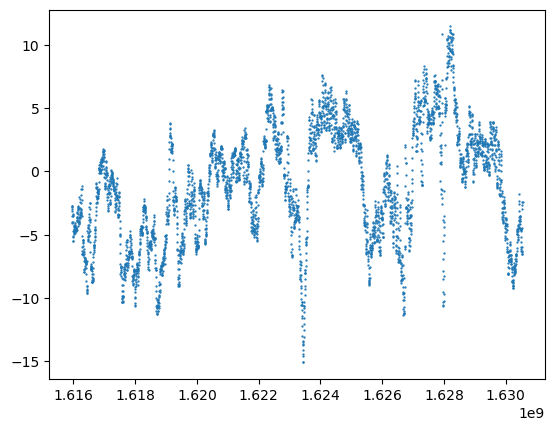

In [92]:
plt.scatter(time_1h_02, wrf_u_mean_02, s=0.4)

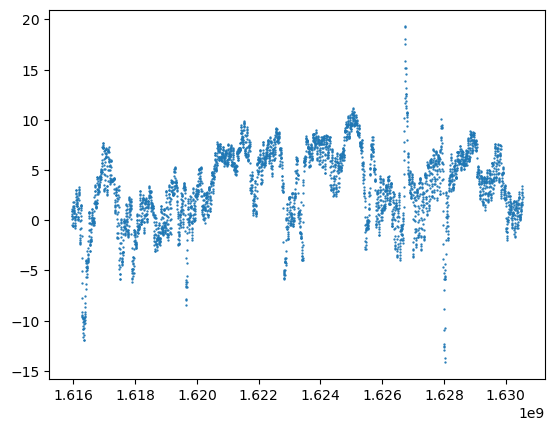

In [93]:
plt.scatter(time_1h_02, wrf_v_mean_02, s=0.4)

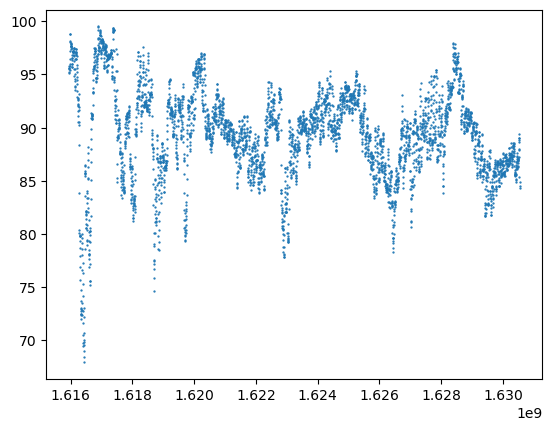

In [94]:
plt.scatter(time_1h_02, wrf_rh2_mean_02, s=0.4)

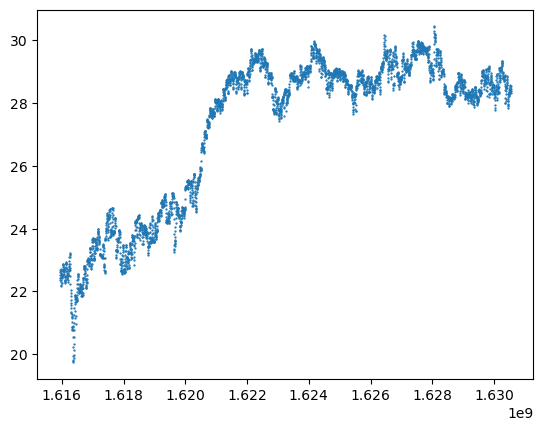

In [95]:
plt.scatter(time_1h_02, wrf_t2_mean_02, s=0.4)

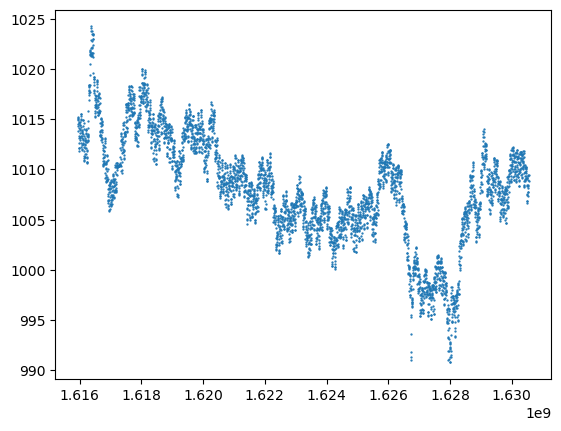

In [96]:
plt.scatter(time_1h_02, wrf_slp_mean_02, s=0.4)

### 保存1hr平均数据

In [97]:
# # 将数据存储在一个字典中
axis_1h_02 = {'time': time_1h_02} # 经纬度感觉要加上
label_1h_02 = {'velocity': real_velocity_mean_02, 'degree': real_degree_mean_02}
feature_1h_02 = {'velocity': wrf_velocity_mean_02, 'degree': wrf_degree_mean_02, 
                'u': wrf_u_mean_02, 'v': wrf_v_mean_02, 'rh2': wrf_rh2_mean_02, 
                 't2': wrf_t2_mean_02, 'slp': wrf_slp_mean_02}

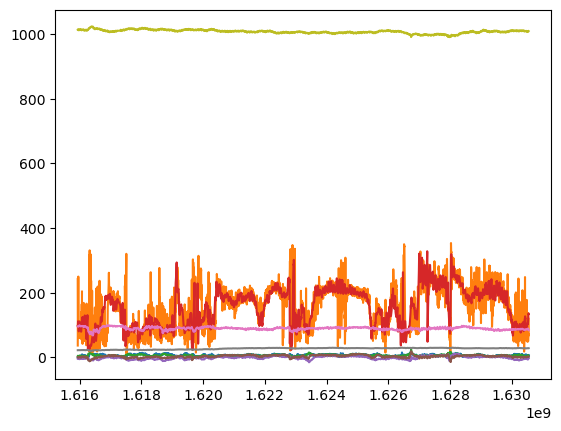

In [98]:
# 绘图查看保存是否正确
for key, value in label_1h_02.items():
    plt.plot(time_1h_02, value)
for key, value in feature_1h_02.items():
    plt.plot(time_1h_02, value)

In [99]:
# # 保存数据
sio.savemat('../data/axis_1h_02.mat', axis_1h_02)
sio.savemat('../data/label_1h_02.mat', label_1h_02)
sio.savemat('../data/feature_1h_02.mat', feature_1h_02)

### 训练模型

In [100]:
# 导入模块
import torch
import torch.nn as nn
import torch.optim as optim

In [101]:
# 构建一个LSTM模型
class MyLSTM(nn.Module):
    """
    
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        
        """
        # 继承父类的初始化方法
        super(MyLSTM, self).__init__()
        # 定义类属性
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # 定义模型
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [102]:
# 编写训练逻辑

def training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, feature_val, label_val):
    """
    
    """
    # 选择模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # 移动到device上运算
    model.to(device)
    feature_train = feature_train.to(device)
    label_train = label_train.to(device)
    feature_val = feature_val.to(device)
    label_val = label_val.to(device)
    
    # 初始化上一轮的loss_train
    loss_train_previous = 0
    for epoch in range(1, n_epochs + 1):
        
        predict_train = model(feature_train)
        loss_train = loss_fn(predict_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()
            
        with torch.no_grad():
                predict_val= model(feature_val)
                loss_val = loss_fn(predict_val, label_val)
                
        if epoch % 200 == 0:
            print('Epoch: %d, \t Loss_train: %f, \t Loss_val: %f' % (epoch, float(loss_train), float(loss_val)))
            
        # loss_train不再变化时跳出循环
#         print(loss_train, loss_train_previous)
        if loss_train - loss_train_previous == 0:
            break
        
        # 更新loss_train_previous
        loss_train_previous = loss_train

In [175]:
# 数据集构建函数
def create_feature_label(feature_seq, label_seq, time_seq, seq_len, ahead_day):
    """
    
    """
    # 待处理特征片段 和 构建标签
    if ahead_day == 0:
        x = feature_seq
        t = time_seq[seq_len - 1:, :]
    else:
        x = feature_seq[0: -ahead_day, :]
        t = time_seq[seq_len - 1: -ahead_day, :]
    y = label_seq[seq_len + ahead_day - 1:, :]
    
    # 计算样本量
    B, V = feature_seq.shape
    sample_num = B - seq_len - ahead_day + 1
    # 构建容器
    feature, label = np.empty((sample_num, seq_len, V)), np.empty((sample_num, 1))
    time_axis = np.empty((sample_num, 1))
    # 循环写入
    for i in range(sample_num):
        feature[i, :, :] = x[i: i + seq_len, :]
        label[i] = y[i, :]
        time_axis[i] = t[i, :]
    return feature, label, time_axis

In [199]:
# 加载数据
axis = sio.loadmat('../data/axis_1h_02.mat')
feature_raw = sio.loadmat('../data/feature_1h_02.mat')
label_raw = sio.loadmat('../data/label_1h_02.mat')

# 堆叠数据
data_list = []
for i, (key, value) in enumerate(feature_raw.items()):
    if key[0] == '_':
        pass
    else:
        print(i - 3, ': ', key)
        data_list.append(value)

0 :  velocity
1 :  degree
2 :  u
3 :  v
4 :  rh2
5 :  t2
6 :  slp


In [200]:
# 构建原始时间轴
time_raw = axis['time'].T

In [201]:
# 构建特征数据集
variable_num = [0, 2, 5]
feature_dataset = np.concatenate(data_list, axis=0).T[:, variable_num]
# 构建标签数据集--此处为 风速
label_dataset = label_raw['velocity'].T

In [203]:
print(feature_dataset.shape, label_dataset.shape, time_raw.shape)

(4058, 3) (4058, 1) (4058, 1)


In [202]:
# 归一化--标准化归一化
feature_mean = np.mean(feature_dataset, axis=0)
feature_std = np.std(feature_dataset, axis=0)
# label_mean = np.mean(label_dataset, axis=0)
# label_std = np.std(label_dataset, axis=0)

feature_norm = (feature_dataset - feature_mean)/feature_std
# label_norm = (label_dataset - label_mean)/label_std

In [205]:
# 构建 特征 和 标签
feature, label, time_axis = create_feature_label(feature_norm, label_dataset, time_raw, 
                                                 seq_len=24 * 1, ahead_day=0)

In [206]:
print(feature.shape, label.shape, time_axis.shape)

(4035, 24, 3) (4035, 1) (4035, 1)


In [207]:
# 训练数据转为tensor对象
feature = torch.from_numpy(feature).to(torch.float32)
label = torch.from_numpy(label).to(torch.float32)

In [208]:
# 划分数据集
sample_num = feature.shape[0]

feature_train = feature[:round(0.7*sample_num),:]
label_train = label[:round(0.7*sample_num),:]
time_train = time_axis[:round(0.7*sample_num),:]

feature_val = feature[round(0.7*sample_num):round(0.8*sample_num),:]
label_val = label[round(0.7*sample_num):round(0.8*sample_num),:]
time_val = time_axis[round(0.7*sample_num):round(0.8*sample_num),:]

feature_test = feature[round(0.8*sample_num):,:]
label_test = label[round(0.8*sample_num):,:]
time_test = time_axis[round(0.8*sample_num):,:]

In [209]:
# 定义模型
# input_size, hidden_size, num_layers, output_size
input_size = 3
hidden_size = 100
num_layers = 1
output_size = 1
model = MyLSTM(input_size, hidden_size, num_layers, output_size)
# 训练次数
n_epochs = 3000
# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-2)
# 损失函数
loss_fn = nn.MSELoss()
# 训练模型
training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, 
              feature_val, label_val)
# model设置为评估模式
model.eval()
# 取消自动求导
for param in model.parameters():
    param.requires_grad = False
# 手动清除 GPU 缓存
torch.cuda.empty_cache()
# 转回cpu
model.to(torch.device("cpu"))
# 计算预测值
predictions = model(feature_test)
# 转为numpy数组
label_test_np = np.squeeze(label_test.numpy())
predictions_np = np.squeeze(predictions.numpy())
# 计算度量
rmse = np.sqrt(np.mean((predictions_np - label_test_np)**2))
corrcoef = np.corrcoef(predictions_np, label_test_np)[0, 1]
print(rmse, corrcoef)

cuda
Epoch: 200, 	 Loss_train: 3.864068, 	 Loss_val: 5.296235
Epoch: 400, 	 Loss_train: 3.324571, 	 Loss_val: 4.107885
Epoch: 600, 	 Loss_train: 2.539589, 	 Loss_val: 4.045315
Epoch: 800, 	 Loss_train: 2.267524, 	 Loss_val: 3.975539
Epoch: 1000, 	 Loss_train: 2.187495, 	 Loss_val: 4.603929
Epoch: 1200, 	 Loss_train: 1.866750, 	 Loss_val: 4.157608
Epoch: 1400, 	 Loss_train: 1.558777, 	 Loss_val: 4.372559
Epoch: 1600, 	 Loss_train: 1.443403, 	 Loss_val: 4.614852
Epoch: 1800, 	 Loss_train: 1.353261, 	 Loss_val: 5.100241
Epoch: 2000, 	 Loss_train: 1.197673, 	 Loss_val: 5.532414
Epoch: 2200, 	 Loss_train: 0.966120, 	 Loss_val: 7.434874
Epoch: 2400, 	 Loss_train: 0.839866, 	 Loss_val: 7.371403
Epoch: 2600, 	 Loss_train: 0.697058, 	 Loss_val: 7.043614
Epoch: 2800, 	 Loss_train: 0.600546, 	 Loss_val: 6.850544
Epoch: 3000, 	 Loss_train: 0.516584, 	 Loss_val: 7.846742
2.5669968 0.47420271089788324


In [211]:
# 训练集
velocity_train_feature = feature_train[:, -1, 0].numpy().flatten() * feature_std[0] + feature_mean[0]

velocity_train_label = label_train.numpy().flatten()
velocity_train_prediction = model(feature_train).numpy().flatten()

In [216]:
# 测试集
velocity_test_feature = feature_test[:, -1, 0].numpy().flatten() * feature_std[0] + feature_mean[0]

velocity_test_label = label_test.numpy().flatten()
velocity_test_prediction = model(feature_test).numpy().flatten()

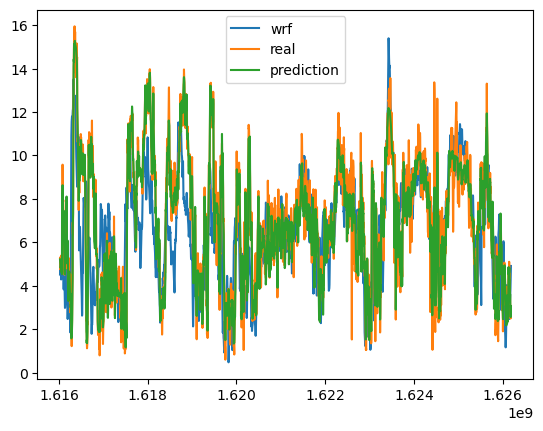

In [215]:
# 绘制对比图
plt.plot(time_train, velocity_train_feature, label='wrf')
plt.plot(time_train, velocity_train_label, label='real')
plt.plot(time_train, velocity_train_prediction, label='prediction')
plt.legend()
plt.show()

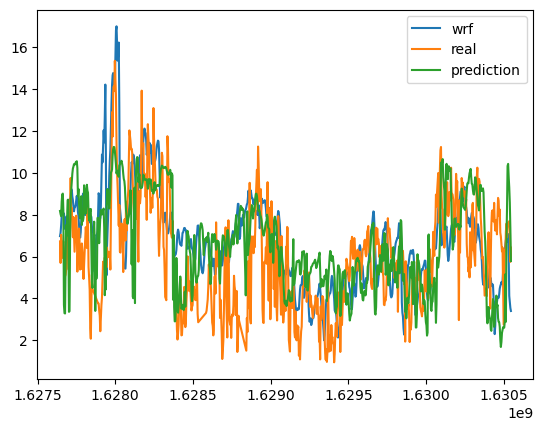

In [217]:
# 绘制对比图
plt.plot(time_test, velocity_test_feature, label='wrf')
plt.plot(time_test, velocity_test_label, label='real')
plt.plot(time_test, velocity_test_prediction, label='prediction')
plt.legend()
plt.show()